<a target="_blank" href="https://colab.research.google.com/github/victorlymarev/pandas/blob/main/notebooks/20-time-series-and-windows.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Временные ряды
#### [Ссылка на видео](https://youtu.be/XxMtQPDesjQ)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

Читаем данные

In [2]:
path_ltc_sample = '../tables/ltc_sample.parquet' if os.path.exists('../tables/ltc_sample.parquet') else 'https://drive.google.com/uc?id=1XaThogOOqKjJj50LvfJ9WqutjMAC5AxA'

ltc = pd.read_parquet(path_ltc_sample)
ltc.head()

,date,price,volume
0,2013-11-13 15:00:56,5.00,12.874000
1,2013-11-13 15:58:20,5.00,0.900000
2,2013-11-16 18:58:57,4.30,0.067440
3,2013-11-16 18:59:16,4.25,5.000000
4,2013-11-19 03:24:48,9.90,0.117018


#### Рисуем графики

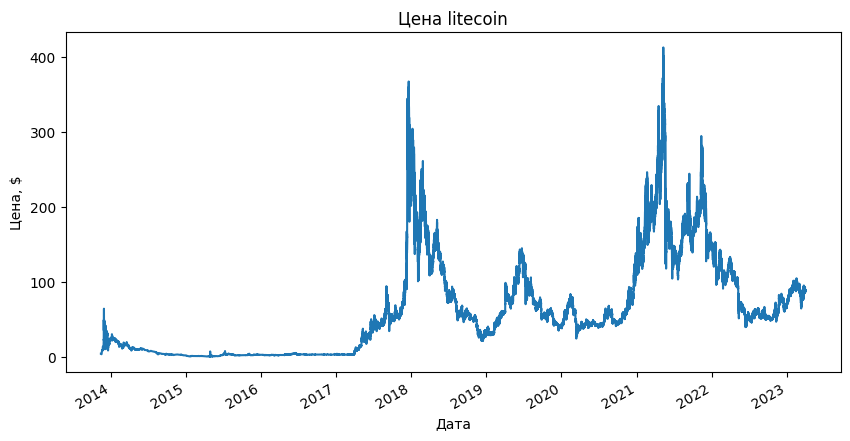

In [3]:
plt.figure(figsize=(10, 5))
ltc.set_index('date')['price'].plot()
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.title('Цена litecoin')
plt.show()

### Делаем лаги

In [4]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_1 = lambda x: x['price'].shift(1))
    .assign(shift_2 = lambda x: x['price'].shift(2))
)

,price,shift_1,shift_2
563279,117.12,NaN,NaN
682710,62.90,117.12,NaN
821866,87.50,62.90,117.12
1145589,265.89,87.50,62.90
1762037,55.42,265.89,87.50


In [5]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(shift_minus_1 = lambda x: x['price'].shift(-1))
    .assign(shift_minus_2 = lambda x: x['price'].shift(-2))
)

,price,shift_minus_1,shift_minus_2
563279,117.12,62.90,87.50
682710,62.90,87.50,265.89
821866,87.50,265.89,55.42
1145589,265.89,55.42,NaN
1762037,55.42,NaN,NaN


#### Разница с предыдущим значением

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(diff_1 = lambda x: x['price'].diff(1))
    .assign(diff_manual_1 = lambda x: x['price'] - x['price'].shift(1))

    .assign(diff_2 = lambda x: x['price'].diff(2))
    .assign(diff_manual_2 = lambda x: x['price'] - x['price'].shift(2))
)

#### Прирост к предыдущему наблюдению

In [ ]:
(ltc[['price']]
    .sample(5, random_state=123)
    .sort_index()
    .assign(pct_change_1 = lambda x: x['price'].pct_change(1))
    .assign(pct_change_manual_1 = lambda x: x['price'] / x['price'].shift(1) - 1)

    .assign(pct_change_2 = lambda x: x['price'].pct_change(2))
    .assign(pct_change_manual_2 = lambda x: x['price'] / x['price'].shift(2) - 1)
)

## Приводим временной ряд к фиксированной частоте

In [6]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.00,12.874000
2013-11-13 15:58:20,5.00,0.900000
2013-11-16 18:58:57,4.30,0.067440
2013-11-16 18:59:16,4.25,5.000000
2013-11-19 03:24:48,9.90,0.117018


In [7]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min')
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.0,12.874
2013-11-13 15:30:56,NaN,NaN
2013-11-13 16:00:56,NaN,NaN
2013-11-13 16:30:56,NaN,NaN
2013-11-13 17:00:56,NaN,NaN


Заполняем последним доступным значением

In [8]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .asfreq(freq='30 min', method='ffill') # method='pad'
    .head()
)

,price,volume
date,,
2013-11-13 15:00:56,5.0,12.874
2013-11-13 15:30:56,5.0,12.874
2013-11-13 16:00:56,5.0,0.900
2013-11-13 16:30:56,5.0,0.900
2013-11-13 17:00:56,5.0,0.900


In [ ]:
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    ['price']
    .asfreq(freq='30 min', method='backfill') # method='bfill'
    .head()
)

In [ ]:
# Можно поменять индекс первого наблюдения
(ltc
    .drop_duplicates('date', keep='last')
    .set_index('date')
    .rename({pd.Timestamp('2013-11-13 15:00:56'): pd.Timestamp('2013-10-24 15:00')}) # не забудьте обернуть Timestamp
    .asfreq(freq='30 min', method='ffill') # method='bfill'
    .head()
)

## Окна

### resemple

In [9]:
ltc.tail(10000).resample('30 min', on='date').apply(lambda x: list(x))

,price,volume
date,,
2023-03-22 20:00:00,"[82.11, 82.35, 82.37, 83.17, 83.2, 83.2, 83.36...","[0.2475, 0.67058101, 6.5, 0.99029232, 0.426831..."
2023-03-22 20:30:00,"[83.46, 83.36, 83.5, 83.49, 83.48, 83.46, 83.4...","[0.22114101, 1.9657, 0.09494336, 11.06042298, ..."
2023-03-22 21:00:00,"[86.74, 86.75, 87.0, 87.0, 87.0, 87.0, 87.06, ...","[7.43e-06, 1.63140257, 2.08729533, 1.0, 0.1185..."
2023-03-22 21:30:00,"[86.58, 86.76, 86.74, 86.83, 86.89, 86.79, 86....","[4.0, 0.09427302, 1.7486907, 0.19683366, 1.601..."
2023-03-22 22:00:00,"[85.97, 85.99, 86.0, 86.0, 86.0, 86.0, 86.02, ...","[1.57348669, 3.39284077, 5.38101776, 8.4483625..."
...,...,...
2023-03-31 21:30:00,"[89.69, 89.71, 89.99, 89.94, 89.94, 89.98, 89....","[5.74249123, 2.35713426, 0.49334389, 0.1342986..."
2023-03-31 22:00:00,"[89.95, 89.91, 89.85, 89.86, 89.93, 90.05, 90.03]","[3.73812782, 1.7934088, 2.96755156, 0.1446472,..."
2023-03-31 22:30:00,"[90.08, 90.12, 90.13, 90.12, 90.14, 90.13, 90....","[5.55802578, 0.7322756, 4.58355146, 7.56720473..."


In [10]:
ltc.resample('30 min', on='date')

In [ ]:
ltc.set_index('date').resample('30 min')

### После окон можно использовать те же функции, что и после groupby

In [11]:
ltc.resample('30 min', on='date')['price'].mean()

,price
date,
2013-11-13 15:00:00,5.000000
2013-11-13 15:30:00,5.000000
2013-11-13 16:00:00,NaN
2013-11-13 16:30:00,NaN
2013-11-13 17:00:00,NaN
...,...
2023-03-31 21:30:00,89.990345
2023-03-31 22:00:00,89.940000
2023-03-31 22:30:00,90.108824


#### Открытие (первое значение), максимум, минимум, закрытие (последнее значение)

In [12]:
ltc.resample('30 min', on='date')['price'].ohlc()

,open,high,low,close
date,,,,
2013-11-13 15:00:00,5.00,5.00,5.00,5.00
2013-11-13 15:30:00,5.00,5.00,5.00,5.00
2013-11-13 16:00:00,NaN,NaN,NaN,NaN
2013-11-13 16:30:00,NaN,NaN,NaN,NaN
2013-11-13 17:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-03-31 21:30:00,89.69,90.12,89.69,90.01
2023-03-31 22:00:00,89.95,90.05,89.85,90.03
2023-03-31 22:30:00,90.08,90.15,90.06,90.11


#### agg

In [13]:
ltc.resample('30 min', on='date')['price'].agg(['mean', 'max'])

,mean,max
date,,
2013-11-13 15:00:00,5.000000,5.00
2013-11-13 15:30:00,5.000000,5.00
2013-11-13 16:00:00,NaN,NaN
2013-11-13 16:30:00,NaN,NaN
2013-11-13 17:00:00,NaN,NaN
...,...,...
2023-03-31 21:30:00,89.990345,90.12
2023-03-31 22:00:00,89.940000,90.05
2023-03-31 22:30:00,90.108824,90.15


#### Первое значение

In [ ]:
ltc.resample('30 min', on='date')['price'].first()

#### Последнее значение

In [ ]:
ltc.resample('30 min', on='date')['price'].last()

#### Можно использовать свои функции

In [14]:
ltc.set_index('date')['price'].resample('d').agg(lambda x: x.iloc[::10].mean())

,price
date,
2013-11-13,5.000000
2013-11-14,NaN
2013-11-15,NaN
2013-11-16,4.300000
2013-11-17,NaN
...,...
2023-03-27,90.372232
2023-03-28,87.363587
2023-03-29,91.243333


## rolling

Скользящее окно

In [15]:
path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

,Цена,Откр.,Макс.,Мин.
Дата,,,,
2018-02-01,180.733,179.880,183.409,178.371
2019-02-01,179.218,179.143,180.669,177.728
2021-02-01,229.402,228.290,229.627,226.187
2022-02-01,311.075,315.381,317.571,305.878
2018-03-01,180.570,179.994,182.500,178.843


In [16]:
stocks['Цена'].head()

,Цена
Дата,
2018-02-01,180.733
2019-02-01,179.218
2021-02-01,229.402
2022-02-01,311.075
2018-03-01,180.570


In [17]:
[list(window) for window in stocks['Цена'].round(3).rolling(window=4)][:10]

[[180.733],
 [180.733, 179.218],
 [180.733, 179.218, 229.402],
 [180.733, 179.218, 229.402, 311.075],
 [179.218, 229.402, 311.075, 180.57],
 [229.402, 311.075, 180.57, 171.659],
 [311.075, 180.57, 171.659, 237.103],
 [180.57, 171.659, 237.103, 173.481],
 [171.659, 237.103, 173.481, 181.476],
 [237.103, 173.481, 181.476, 245.93]]

In [ ]:
stocks['Цена'].rolling(window=4).mean().head(8)

In [ ]:
stocks['Цена'].rolling(window=4, min_periods=1).mean().head(8)

#### Взять каждое второе наблюдение можно при помощи своей функции

In [ ]:
(stocks
    ['Цена']
    .rolling(window=10, min_periods=1)
    .agg(['mean', lambda x: x[::2].mean()])
    .set_axis(['Среднее', 'Среднее за каждое второе наблюдение'], axis=1)
    .head()
)

### expanding

Расширяющееся окно

In [25]:
stocks['Цена'].expanding().sum()

,Цена
Дата,
2018-02-01,180.733
2019-02-01,359.951
2021-02-01,589.353
2022-02-01,900.428
2018-03-01,1080.998
...,...
2021-08-31,265154.287
2022-08-31,265372.992
2018-10-31,265538.761


In [19]:
stocks['Цена'].cumsum()

,Цена
Дата,
2018-02-01,180.733
2019-02-01,359.951
2021-02-01,589.353
2022-02-01,900.428
2018-03-01,1080.998
...,...
2021-08-31,265154.287
2022-08-31,265372.992
2018-10-31,265538.761


In [20]:
stocks['Цена'].expanding().mean()

,Цена
Дата,
2018-02-01,180.733000
2019-02-01,179.975500
2021-02-01,196.451000
2022-02-01,225.107000
2018-03-01,216.199600
...,...
2021-08-31,217.161578
2022-08-31,217.162841
2018-10-31,217.120818


### ewm

Окно с экспоненциально взвешенными операциями

In [ ]:
stocks['Цена'].ewm(alpha=0.5)

**adjust=True**
![image.png](attachment:image.png)

**adjust=False**

![image.png](attachment:image.png)

In [ ]:
stocks['Цена'].ewm(alpha=0.5).mean()

# Задания

#### Описание таблиц лежит [здесь](https://github.com/victorlymarev/pandas/tree/main/tables#%D0%BE%D0%BF%D0%B8%D1%81%D0%B0%D0%BD%D0%B8%D0%B5-%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86)

Некоторые таблицы занимают много памяти, поэтому каждые 5-10 заданий лучше перезапускайте ноутбук.

В формулировке некоторых заданий может содержаться вариативность. Если у вас есть сомнения, что требуется в задании, попробуйте решить несколько вариантов. Если вы не понимаете задание, можете написать об этом в комментариях под видео.

В большинстве случаев внешний вид итоговой таблицы не определен. Выведите на экран наиболее адекватный вариант. То есть таблицу, из которой можно будет сделать выводы.

Курс пока находится в разработке. Вы можете помочь другим людям добавив свое решение [сюда](https://docs.google.com/forms/d/1HYTBz_KfssY3Jps2dC3n0YnEqa6WBb5OIhLo1d32Xzw/edit).

Посмотреть решения других людей можно [здесь](https://docs.google.com/spreadsheets/d/1pMDYO-9UneLbPPnEuQ2shig0TOJdQTU-zipifyAnZMk/edit?resourcekey#gid=1998648012)

### Задание 1

Для каждой даты выясните ли следующий день выходным (True если выходной, False если нет)

In [28]:
import os
import pandas as pd

path_w_ends = '../tables/выходные.csv' if os.path.exists('../tables/выходные.csv') else 'https://drive.google.com/uc?id=1hAsoXSPTFihFmBuF-E0uSj9pX4gpojwC'

w_ends = pd.read_csv(path_w_ends)
w_ends.head(20)

,Дата,выходной
0,2015-01-01,True
1,2015-01-02,True
2,2015-01-03,True
3,2015-01-04,True
4,2015-01-05,True
5,2015-01-06,True
6,2015-01-07,True
7,2015-01-08,True
8,2015-01-09,True
9,2015-01-10,True


In [37]:
# напишите свой код здесь

w_ends['Следующий выходной'] = w_ends['выходной'].shift(-1)

print(w_ends.head(30))

          Дата  выходной Следующий выходной
0   2015-01-01      True               True
1   2015-01-02      True               True
2   2015-01-03      True               True
3   2015-01-04      True               True
4   2015-01-05      True               True
5   2015-01-06      True               True
6   2015-01-07      True               True
7   2015-01-08      True               True
8   2015-01-09      True               True
9   2015-01-10      True               True
10  2015-01-11      True              False
11  2015-01-12     False              False
12  2015-01-13     False              False
13  2015-01-14     False              False
14  2015-01-15     False              False
15  2015-01-16     False               True
16  2015-01-17      True               True
17  2015-01-18      True              False
18  2015-01-19     False              False
19  2015-01-20     False              False
20  2015-01-21     False              False
21  2015-01-22     False        

### Задание 2

Постройте график суммарной выручки магазина 1 за каждый день. На том же графике разметите сглаженный график (тип сглаживания и длинну интервала сглаживания определите сами)

In [38]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

,check_id,customer_id,purchase_date,shop_id,product_code_1,product_code_2,product_code_3,cashier,shop_assistant,price,goods_number
0,1,1,2015-01-22 10:18:01,1,17987,202200764,202200776,1,7,1499.9,1
1,4,<NA>,2015-01-22 11:25:49,1,251,202974794,202974810,0,8,1099.9,1
2,11,11,2015-01-22 13:17:51,1,24616,23587775,23587813,0,7,399.9,1
3,14,14,2015-01-22 13:57:41,1,10823,202188456,202188476,1,8,799.9,1
4,32,33,2015-01-22 17:53:23,1,18216,203693116,203693163,0,8,699.9,2


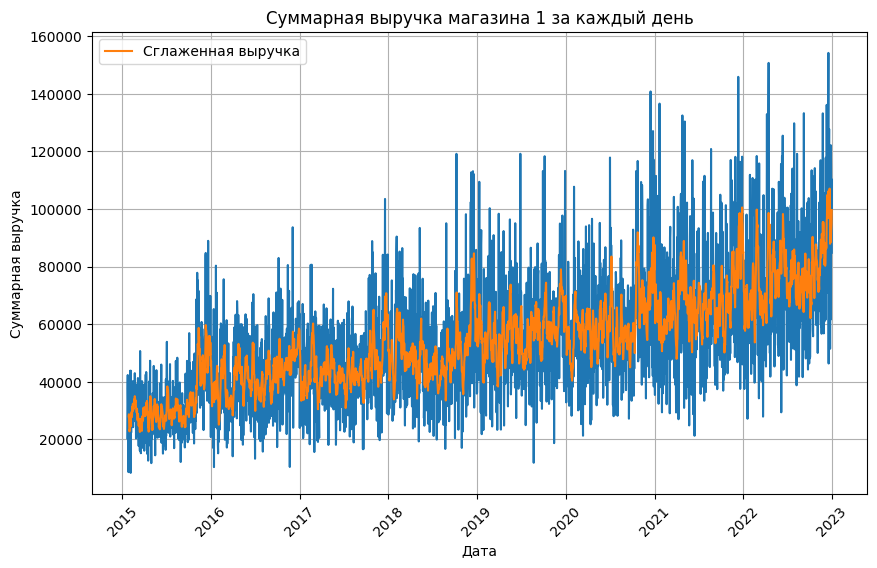

In [46]:

import pandas as pd
import matplotlib.pyplot as plt

sales_shop_1 = sales[sales['shop_id'] == 1]

daily_revenue = sales_shop_1.groupby(sales_shop_1['purchase_date'].dt.date)['price'].sum()

plt.figure(figsize=(10, 6))
plt.plot(daily_revenue.index, daily_revenue.values)

# Используем скользящее среднее с интервалом 7 дней
smoothed_revenue = daily_revenue.rolling(window=7).mean()
plt.plot(smoothed_revenue.index, smoothed_revenue.values, label='Сглаженная выручка')

plt.xlabel('Дата')
plt.ylabel('Суммарная выручка')
plt.title('Суммарная выручка магазина 1 за каждый день')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.show()


### Задание 3

Для каждого месяца посчитать отношения числа проданных товаров в этом месяце к предыдущему, а так же прирост в выручке

In [47]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

,check_id,customer_id,purchase_date,shop_id,product_code_1,product_code_2,product_code_3,cashier,shop_assistant,price,goods_number
0,1,1,2015-01-22 10:18:01,1,17987,202200764,202200776,1,7,1499.9,1
1,4,<NA>,2015-01-22 11:25:49,1,251,202974794,202974810,0,8,1099.9,1
2,11,11,2015-01-22 13:17:51,1,24616,23587775,23587813,0,7,399.9,1
3,14,14,2015-01-22 13:57:41,1,10823,202188456,202188476,1,8,799.9,1
4,32,33,2015-01-22 17:53:23,1,18216,203693116,203693163,0,8,699.9,2


In [52]:
# напишите свой код здесь
monthly_sales = sales.groupby(sales['purchase_date'].dt.strftime('%B %Y')).agg([
    ('product_code_2', 'count'),
    ('price', 'sum')
])
monthly_sales['отношение_товаров'] = monthly_sales['количество_товаров'].pct_change()
monthly_sales['прирост_выручки'] = monthly_sales['выручка'].pct_change()
print(monthly_sales)


TypeError: datetime64 type does not support sum operations

### Задание 4

Посчитать VaR и ES (на уровне 95%) для цены акций на 1 и на 10 торговых дней

VaR (value at risk) (на уровне 95%) - это 95 квантиль потерь (или пятый квантиль доходностей)

ES (expected shortfall) (на уровне 95%) - это средние убытки при условии, что состоялся неблагоприятный сценарий и убытки пробили 95% порог

In [ ]:
import os
import pandas as pd

path_stocks = '../tables/stocks.parquet' if os.path.exists('../tables/stocks.parquet') else 'https://drive.google.com/uc?id=1weGquTtmR92mKYAeZhZCFHJjndyoSXZt'

stocks = pd.read_parquet(path_stocks)
stocks.head()

In [ ]:
# напишите свой код здесь

### Задание 5

Для каждого сотрудника посчитать среднюю оценку за 3 месяца и за полгода. Предварительно приведите колонку с оценкой сотрудника к типу float

In [53]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

,report_dt,i_pernr,fio,sex,shop_id,pos_name,pos_id,closest_boss_pos_id,mgmt_flag,salary_fork,birth_date,education,employee_evaluation,salary
0,2015-01-31,100000,Кожевников Андрей Максимович,мужской,1,Директор магазина,11,<NA>,1,0,1987-03-11,высшее,5.0,45700.0
1,2015-01-31,0,Дубинина Надежда Николаевна,женский,1,Старший кассир,12,11,0,0,1971-07-07,среднее профессиональное,5.0,20000.0
2,2015-01-31,1,Вишневскиая Валентина Константиновна,женский,1,Кассир,13,12,0,0,1974-11-29,среднее общее,5.0,12600.0
3,2015-01-31,2,Литвинов Александр Максимович,мужской,1,Кассир,14,12,0,0,1969-11-01,среднее общее,3.0,12600.0
4,2015-01-31,3,Черняева Валерия Глебовна,женский,1,Продавец-консультант,17,11,0,0,1988-07-17,среднее общее,NaN,15400.0


In [55]:
# напишите свой код здесь
import pandas as pd

df = empl

df['employee_evaluation'] = df['employee_evaluation'].astype(float)

df['average_3_months'] = df.groupby('i_pernr')['employee_evaluation'].transform(lambda x: x.rolling(3).mean())

df['average_6_months'] = df.groupby('i_pernr')['employee_evaluation'].transform(lambda x: x.rolling(6).mean())
df


,report_dt,i_pernr,fio,sex,shop_id,pos_name,pos_id,closest_boss_pos_id,mgmt_flag,salary_fork,birth_date,education,employee_evaluation,salary,average_3_months,average_6_months
0,2015-01-31,100000,Кожевников Андрей Максимович,мужской,1,Директор магазина,11,<NA>,1,0,1987-03-11,высшее,5.0,45700.0,NaN,NaN
1,2015-01-31,0,Дубинина Надежда Николаевна,женский,1,Старший кассир,12,11,0,0,1971-07-07,среднее профессиональное,5.0,20000.0,NaN,NaN
2,2015-01-31,1,Вишневскиая Валентина Константиновна,женский,1,Кассир,13,12,0,0,1974-11-29,среднее общее,5.0,12600.0,NaN,NaN
3,2015-01-31,2,Литвинов Александр Максимович,мужской,1,Кассир,14,12,0,0,1969-11-01,среднее общее,3.0,12600.0,NaN,NaN
4,2015-01-31,3,Черняева Валерия Глебовна,женский,1,Продавец-консультант,17,11,0,0,1988-07-17,среднее общее,NaN,15400.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29367,2022-12-31,1372,Морозова Раиса Ярославовна,женский,23,Продавец-консультант,2325,232,0,2,1962-01-13,среднее профессиональное,6.0,38000.0,6.000000,6.000000
29368,2022-12-31,1615,Фадеева Евгения Данииловна,женский,23,Товаровед,2326,233,0,1,1989-07-12,среднее общее,6.0,31800.0,6.000000,5.500000
29369,2022-12-31,1748,Измайлов Григорий Артемович,мужской,23,Товаровед,2327,233,0,0,1989-12-23,среднее общее,3.0,28400.0,3.333333,3.666667
29370,2022-12-31,1616,Русаков Евгений Тимурович,мужской,23,Мастер по ремонту одежды,2328,232,0,2,1963-09-19,среднее профессиональное,7.0,35500.0,7.000000,7.000000


### Задание 6

Для каждого сотрудника почитайте его среднюю оценку по состоянию на каждый месяц. То есть если сотрудник пропаботал год, то для каждого месяца его работы должна быть вычислена средняя оценки за предыдущие месяца его работы. Предварительно приведите колонку с оценкой сотрудника к типу float

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 7

Постройте график числа чеков в день за первые 30 дней работы, по каждому магазину

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 8

Посмотрите на среднюю оценку каждого сотрудника. Если в последние 3 месяца она не падает, то отметьте сотрудника как полезного. Если она не растет, то отметьте сотрудника как неполезного. Иначе поставьте NaN

In [ ]:
import os
import pandas as pd

path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 9

По таблице prices найти товары которые были в продаже, потом исчезли, но затем вернулись

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 10

Для каждого клиента и чека найти дату предыдущей покупки

То есть таблица должна содержать колонки номер чека (поле без дубликатов), id клиента, дата покупки, дата предыдущей покупки

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_sample на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_sample = '../tables/sales_sample.parquet' if os.path.exists('../tables/sales_sample.parquet') else 'https://drive.google.com/uc?id=1BgxAxPauzC4LObY3N65PgAvnU3f5QRj2'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_sample)
sales.head()

In [ ]:
# напишите свой код здесь

### Задание 11

Для каждого товара посчитайте, насколько цена товара сейчас выше своего среднего заначения за предыдущие 4 месяца

In [ ]:
import os
import pandas as pd

path_prices = '../tables/prices.parquet' if os.path.exists('../tables/prices.parquet') else 'https://drive.google.com/uc?id=1_KfYyYCsib8woanbP3VouLUpYp103dV5'

prices = pd.read_parquet(path_prices)
prices.head()

In [ ]:
# напишите свой код здесь

### Задание 12

На конец каждого месяца посчитайте, сколько дней проработал сотрудник. Если сотрудник увольнялся, необходимо учитывать предыдущий стаж


<details>

<summary>Подсказка</summary>

Здесь можно для каждого периода работы для каждого сотрудника посчитать, сколько дней он отработал. Отсортировать эти периоды по дате начала работы и посчитать накопленную сумму числа дней. Сдвинуть это значение на 1 период период и для первого периода начала работы заполнить нулем. Затем это значение можно смерджить с основной таблицей и прибавить это накопленное значение к числу дней работы с момента последнего устройства на работу.

</details>

In [ ]:
import os
import pandas as pd

path_events = '../tables/events.parquet' if os.path.exists('../tables/events.parquet') else 'https://drive.google.com/uc?id=1Phn06U4-BI0XqtYAgtlM6IuoXRIAGQlO'

events = pd.read_parquet(path_events)
events.head()

In [ ]:
path_empl = '../tables/employees.parquet' if os.path.exists('../tables/employees.parquet') else 'https://drive.google.com/uc?id=1AARD5-eVlCxoApt5CYZebrC3Cqw42lvj'

empl = pd.read_parquet(path_empl)
empl.head()

In [ ]:
# напишите свой код здесь

### Задание 13

Необходимо посчитать с какой скоростью кассир обслуживает клиетов. Но сделать это надо не просто разделив рабочий день на количество заказов, а немного умнее.

Сначала необходимо выделить сессии. Сессией будем называть период, когда между заказами прошло менее 5 минут и когда этих заказов подряд было не менее 3.

Необходимо посчитать среднее время обслуживание клиента в рамках сессии. Для этого необходимо посчитать общую длинну сессий для каждого кассира и разделить ее на количество клиентов в сессиях минус число сессий у кассира.

<details>

<summary>Подсказка</summary>
    
Возможный вариант решения, который требует некоторых доработок

Сначала надо избавиться от дубликатов чеков. И оставить надо только 3 колонки: номер кассира, номер чека и дата покупки.

Далее еобходимо посчитать сколько больших сессий работы было у кассира. Для этого надо выделить наблюдения для каждого кассира, где разница между продажами была меньше 5 минут. И пометить их 1. Остальные -1. Далее вводим условие, что в сессии больше или равно 3 чеков. Это можно сделать, создав несколько колонок через shift, пометив начало сессии, конец сессии и период внутри сессии (который будет включать крайние значения) или как написано ниже.

Идем по столбцу из 1 и -1 скользящим окном размером 4. На каждом шаге окно домножаем на вектор [-1, 1, 1, 1] и считаем сумму. Если сумма равна 4, то ставим 1 - индикатор, что началась новая сессия, если сумма равна 4 или 2, значит сессия идет. Если значение равно нулю, то значит сессия закончилась на прошлом чеке и прошлое значение надо пометить как конец сессии.

При расчете начала и конца сессии необходимо быть осторожным, что просиходит на краях, чтобы не получить сессию, которая не закончилась.

В конце счиатем количество сессий, число клиентов и время сессий (через merge_asof). Делим одно на другое.

</details>

In [ ]:
# таблица sales - большая, и в некоторых случаях ваш компьютер может не справиться с ее обработкой
# поэтому лучше работайте с частью этой таблицы
# но если вы хотите попробовать поработать с полной версией таблицы,
# можете заменить переменную path_sales_2022 на path_sales внутри функции read_parquet

import os
import pandas as pd

path_sales_2022 = '../tables/sales_2022.parquet' if os.path.exists('../tables/sales_2022.parquet') else 'https://drive.google.com/uc?id=17e7FwXVdsWc2aziK9s5KidIvPcfKt9F5'
# path_sales = '../tables/sales.parquet' if os.path.exists('../tables/sales.parquet') else "https://drive.usercontent.google.com/download?id=15KwSxyM6hpNABGe6_vsrFZvD09VfHFyK&export=download&authuser=1&confirm=t&uuid=115bd48c-cc2c-4f2a-8b42-be5ca6ef6db8&at=APZUnTUVb8nfNANw5wr9Cad7PJ3U:1693327774694"

sales = pd.read_parquet(path_sales_2022)
sales.head()

In [ ]:
# напишите свой код здесь